In [16]:
import torch
import json

# Load the extracted features (list of tensors)
all_features = torch.load('image_features.pt', weights_only=True)  # This is a list of tensors
image_name_to_index = torch.load('image_name_to_index.pt', weights_only=True)

# Load the captions dictionary
with open('captions_dict.json', 'r') as f:
    caption_sequences = json.load(f)

# Load the vocabulary
with open('vocabulary.json', 'r') as vocab_file:
    vocabulary = json.load(vocab_file)

# Debug prints to confirm loading
print(f"Loaded {len(all_features)} features.")
print(f"Loaded {len(caption_sequences)} captions.")
print(f"Loaded {len(vocabulary)} words in the vocabulary.")

Loaded 8091 features.
Loaded 8091 captions.
Loaded 8517 words in the vocabulary.


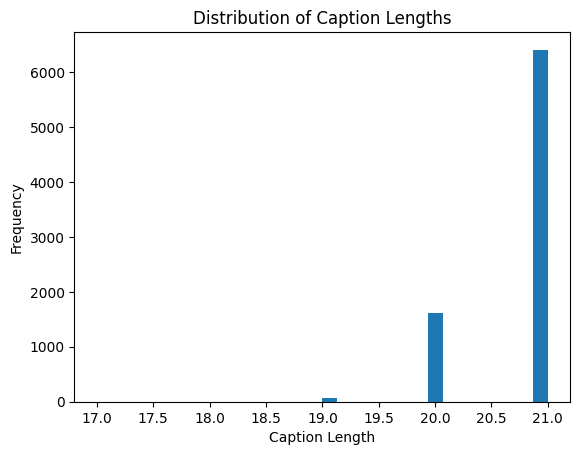

In [3]:
import matplotlib.pyplot as plt

lengths = [len(caption) for caption in caption_sequences]
plt.hist(lengths, bins=30)
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Lengths')
plt.show()


In [4]:
# Check the number of captions for each image
caption_counts = [len(captions) for captions in caption_sequences.values()]

# Print the total number of images and the count of captions for the first 10 images
print(f"Number of images: {len(caption_counts)}")
print(f"Number of captions per image (first 10): {caption_counts[:10]}")


Number of images: 8091
Number of captions per image (first 10): [5, 5, 5, 5, 5, 5, 5, 3, 5, 5]


In [5]:
import torch
from torch.nn.utils.rnn import pad_sequence

def pad_captions(caption_sequences, max_length=21):
    # Determine the maximum number of captions for any image
    max_num_captions = max(len(captions) for captions in caption_sequences.values())
    
    padded_captions = []
    
    for captions in caption_sequences.values():
        padded_for_image = []
        
        for caption in captions:
            # Convert caption to tensor
            tensor_caption = torch.tensor(
                [int(word) if isinstance(word, str) and word.isdigit() else word for word in caption],
                dtype=torch.long
            )
            # Truncate or pad
            if tensor_caption.size(0) < max_length:
                tensor_caption = torch.cat((tensor_caption, torch.zeros(max_length - tensor_caption.size(0), dtype=torch.long)))
            else:
                tensor_caption = tensor_caption[:max_length]  # truncate if too long
            
            padded_for_image.append(tensor_caption)

        # Pad the list of captions to the maximum number of captions for this image
        padded_for_image = pad_sequence(padded_for_image, batch_first=True)
        
        # If there are fewer captions than the max, pad the whole tensor to the maximum number of captions
        if padded_for_image.size(0) < max_num_captions:
            # Pad with zeros for missing captions
            padding_needed = max_num_captions - padded_for_image.size(0)
            padded_for_image = torch.cat((padded_for_image, torch.zeros(padding_needed, max_length, dtype=torch.long)))

        padded_captions.append(padded_for_image)

    # Convert to a single tensor
    return torch.stack(padded_captions)

max_length = 21
padded_captions = pad_captions(caption_sequences, max_length)
print(f"Padded captions shape: {padded_captions.shape}")  # Should be (num_images, max_num_captions, max_length)


Padded captions shape: torch.Size([8091, 5, 21])


In [6]:
# Check the number of features
num_features = len(all_features)
print(f"Number of features: {num_features}")

# Check the number of padded captions
num_padded_captions = len(padded_captions)  # This should be a list now
print(f"Number of padded captions: {num_padded_captions}")

# Check the shape of the first padded caption (if they all have the same shape)
if num_padded_captions > 0:
    first_caption_shape = padded_captions[0][0].shape  # Get the shape of the first padded caption tensor
    print(f"Shape of the first padded caption: {first_caption_shape}")

# Ensure they match the number of images
if num_features == len(caption_sequences):
    print("The number of features matches the number of images.")
else:
    print("Mismatch detected between features and images!")


Number of features: 8091
Number of padded captions: 8091
Shape of the first padded caption: torch.Size([21])
The number of features matches the number of images.


In [7]:
from torch.utils.data import Dataset

class ImageCaptionDataset(Dataset):
    def __init__(self, features, padded_captions, name_to_index, transform=None):
        self.features = features  # List of feature tensors
        self.padded_captions = padded_captions  # List of lists for padded captions
        self.name_to_index = name_to_index  # Dictionary mapping image names to indices
        self.transform = transform

    def __len__(self):
        return len(self.features)  # Return the number of images

    def __getitem__(self, idx):
        image_feature = self.features[idx]  # Access feature directly as it's a list
        caption = self.padded_captions[idx]  # Index padded captions list using the same idx

        if self.transform:
            image_feature = self.transform(image_feature)

        return image_feature, caption


In [8]:
from sklearn.model_selection import train_test_split

# Create a list of image names to ensure proper alignment
image_names = list(caption_sequences.keys())  # Get all image names

# Create corresponding features and captions lists
features_list = [all_features[i] for i in range(len(image_names))]
captions_list = [caption_sequences[name] for name in image_names]  # Ensure alignment with features

# Now pad the captions and convert them to tensors
max_length = 21  # Set this to your desired max length
padded_captions = pad_captions(caption_sequences, max_length)

# Check if we have the same number of features and images
print(f"Number of features: {len(features_list)}")  # Should be 8091
print(f"Number of padded captions: {len(padded_captions)}")  # Should also be 8091

# Create the dataset
dataset = ImageCaptionDataset(features_list, padded_captions, image_name_to_index)

# Split the dataset (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Print the sizes of the training and testing sets
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")



Number of features: 8091
Number of padded captions: 8091
Training set size: 6472
Testing set size: 1619


In [9]:
def collate_fn(batch):
    features, captions = zip(*batch)  # Unzip the batch into features and captions
    features = torch.stack(features)  # Convert features to a tensor
    padded_captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True)  # Pad captions
    return features, padded_captions


In [10]:
from torch.utils.data import DataLoader

# Create data loaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [11]:
import torch
import torch.nn as nn

class ShowTellModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob):
        super(ShowTellModel, self).__init__()

        # Image feature embedding
        self.img_fc = nn.Linear(1000, embedding_dim)  # Ensure feature_dim is 1000 or adjust accordingly

        # Word embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM for caption generation
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout_prob, batch_first=True)

        # Fully connected layer to map LSTM output to the vocabulary size
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # Dropout layer (optional)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, image_features, captions):
        # Process image features
        img_embedding = self.img_fc(image_features).unsqueeze(1)  # [batch_size, 1, embedding_dim]
        
        # Process caption embeddings
        cap_embedding = self.embedding(captions)  # [batch_size, num_captions, seq_length, embedding_dim]
        
        # Print shapes for debugging
        print(f"Image embedding shape: {img_embedding.shape}")
        print(f"Caption embedding shape: {cap_embedding.shape}")
        
        # Adjust the dimensions of cap_embedding
        # Option 1: Squeeze the first dimension (num_captions) if you want to process a single caption
        # cap_embedding = cap_embedding.squeeze(1)  # [batch_size, seq_length, embedding_dim]
        
        # Option 2: Reshape cap_embedding to match the dimensions needed for concatenation
        cap_embedding = cap_embedding.view(cap_embedding.size(0), -1, cap_embedding.size(3))  # [batch_size, num_captions*seq_length, embedding_dim]
        
        # Now, cap_embedding should have 3 dimensions to match img_embedding
        embeddings = torch.cat((img_embedding.repeat(1, cap_embedding.size(1), 1), cap_embedding), dim=1)  # Concatenate
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(embeddings)
    
        # Pass through fully connected layer to get final output
        outputs = self.fc(lstm_out)
    
        return outputs


In [12]:
# Initialize the model
vocab_size = 8517  # You mentioned the vocabulary size
embedding_dim = 256  # Can be adjusted based on your preference
hidden_dim = 512     # Size of the hidden state in the RNN/LSTM
num_layers = 2       # Number of layers in LSTM
dropout_prob = 0.5   # Dropout probability

model = ShowTellModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob)
print("Model initialized!")


Model initialized!


In [13]:
import torch.nn as nn

# Define the loss function
loss_function = nn.CrossEntropyLoss()


In [14]:
import torch.optim as optim

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
num_epochs = 10  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    
    for images, captions in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(images, captions)
        
        # After computing the outputs from your model
        outputs = outputs.view(-1, outputs.size(-1))  # Shape: [batch_size * sequence_length, vocab_size]
        captions = captions.view(-1)  # This will flatten it to [32 * 5 * 21]
        print(f"Outputs shape: {outputs.shape}")  # Should be [batch_size * sequence_length, vocab_size]
        print(f"Captions shape: {captions.shape}")  # Should be [batch_size * sequence_length]

        loss = loss_function(outputs, captions)

        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print the loss for tracking
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")


Image embedding shape: torch.Size([32, 1, 256])
Caption embedding shape: torch.Size([32, 5, 21, 256])
Outputs shape: torch.Size([6720, 8517])
Captions shape: torch.Size([3360])


ValueError: Expected input batch_size (6720) to match target batch_size (3360).